In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_format(title,xlabel,ylabel):
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=11, rotation=0)
    plt.yticks(fontsize=11)   

# READ DATA

## Origination Data

In [3]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_orig_"


column_names=['fico', 'dt_first_pi', 'flag_fthb', 'dt_matr', 'cd_msa', 
              'mi_pct', 'cnt_units','occpy_sts', 'cltv', 'dti', 
              'orig_upb', 'ltv', 'int_rt', 'channel', 'ppmt_pnlty',
              'prod_type', 'st', 'prop_type', 'zipcode', 'id_loan', 
              'loan_purpose','orig_loan_term', 'cnt_borr', 'seller_name', 'servicer_name', 
              'flag_sc','program_ind']

def quarter(time):
    if time == "01" or time == "02" or time == "03": 
        return 'Q1'
    elif time == "04" or time == "05" or time == "06": 
        return 'Q2'
    elif time == "07" or time == "08" or time == "09": 
        return 'Q3'
    else:
        return 'Q4'

def read_file(y):
    file = pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False) # Some columns have mixed types -> use low_memory = False
    file['year'] = file['dt_first_pi'].astype(str).str[:4]
    file['month'] = file['dt_first_pi'].astype(str).str[-2:]
    file['quarter'] = file['year'] + file['month'].apply(quarter)
    return file[file['year'].astype(int) <= 2009]

ori_2008 = read_file(2008)
ori_2009 = read_file(2009)

ori = pd.concat([ori_2008, ori_2009])

ori.to_csv("origination_2008_2009.csv",index=False)
print(ori.shape)

(91579, 30)


## Performance Data

In [4]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_svcg_"

column_names=['id_loan','Period','Act_endg_upb','delq_sts','loan_age',
              'mths_remng','repch_flag','flag_mod','CD_Zero_BAL','Dt_zero_BAL',
              'New_Int_rt','Amt_Non_Int_Brng_Upb','Dt_Lst_Pi','MI_Recoveries','Net_Sale_Proceed',
              'Non_MI_Recoveries','Expenses','legal_costs','maint_pres_costs','taxes_ins_costs',
              'misc_costs','actual_loss','modcost','stepmod_ind','dpm_ind', 
              'eltv','zb_removal_upb','dlq_acrd_int','disaster_hardship_ind','borrower_assist_flag']

chuck_size = 1000 # Help loading big data -> MapReduce

def read_file(y):
    mylist = []
    for chunk in pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False, chunksize = chuck_size): # run functions in different chunks (for loop)
        chunk = chunk[chunk['Period'] <= (y+5)*100] # Selet only 5-year performance for each loan
        mylist.append(chunk)
    per = pd.concat(mylist, axis = 0)
    return per

per_2008 = read_file(2008)
per_2009 = read_file(2009)

performance = pd.concat([per_2008, per_2009])

performance.to_csv("performance_2008_2009.csv",index=False)
print(performance.shape)

(3713474, 30)


# PROJECT 2: RISK/DELINQUENCY MODEL

## Load the data

In [5]:
# Load the data
ori = pd.read_csv("origination_2008_2009.csv",low_memory = False)
per = pd.read_csv("performance_2008_2009.csv",low_memory = False)

In [6]:
# Identify delinquency and combine per and ori

# 1. Add quarter and int_rt from ori
per_deli = pd.merge(ori[['id_loan', 'int_rt','quarter']], per, how = 'inner', on = 'id_loan') 

# 2. Define delinquency
# a. When a loan has 90+ days in delinquency or balance becomes zero
per_deli['delq_sts_num']=pd.to_numeric(per_deli['delq_sts'], errors='coerce') 
per_deli.loc[(per_deli['delq_sts_num'] > 2) | (per_deli['CD_Zero_BAL'].isin(['3.0','6.0','9.0'])),'bad'] = 1 

# b. When a loan has shown recovery amounts or deferred UPB
max_recovery = per_deli.groupby(['id_loan'])['Non_MI_Recoveries', 'MI_Recoveries', 'Amt_Non_Int_Brng_Upb'].max().reset_index()
per_deli = pd.merge(per_deli, max_recovery, on='id_loan')
per_deli.loc[(per_deli['delq_sts']=='R')| (per_deli['Non_MI_Recoveries_y'] > 0) | (per_deli['MI_Recoveries_y'] > 0 ) | 
             (per_deli['Amt_Non_Int_Brng_Upb_y'] > 0), 'bad']=1

# c. When a loan has been modified (such as when interest rate reduction)
per_deli.loc[(per_deli['flag_mod']=='Y'), 'bad']=1

min_new_int_rt = per_deli.groupby('id_loan')[['New_Int_rt']].min().reset_index()
per_deli = pd.merge(per_deli, min_new_int_rt, on='id_loan')
per_deli.loc[per_deli['New_Int_rt_y'] < per_deli['int_rt'], 'bad'] = 1

per_deli['deli']=np.where((per_deli['bad'] > 0), 1, 0)

# 3. Combine with ori
per_deli = per_deli.drop(['Non_MI_Recoveries_x','Non_MI_Recoveries_y','MI_Recoveries_x','MI_Recoveries_y',
                           'Amt_Non_Int_Brng_Upb_x','Amt_Non_Int_Brng_Upb_y','New_Int_rt_x','New_Int_rt_y','bad'], axis=1)
ori_per_deli = pd.merge(ori, per_deli.drop(['quarter','int_rt'],axis=1), how = "inner", on = "id_loan")
ori_per_deli.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,modcost,stepmod_ind,dpm_ind,eltv,zb_removal_upb,dlq_acrd_int,disaster_hardship_ind,borrower_assist_flag,delq_sts_num,deli
0,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
4,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


In [7]:
# Check wether the 'bad' count is enough for modeling
# Check whether the bad rate makes sense

print(ori_per_deli.shape)
print(ori_per_deli['deli'].sum(),"\n")
print(ori_per_deli['deli'].groupby(ori_per_deli['quarter']).mean())

(3407832, 57)
123762 

quarter
2008Q1    0.091530
2008Q2    0.069314
2008Q3    0.071388
2008Q4    0.063545
2009Q1    0.026894
2009Q2    0.006621
2009Q3    0.005480
2009Q4    0.005763
Name: deli, dtype: float64


## Data Cleaning

In [8]:
# Remove the meaningless variables
df = ori_per_deli.drop(['dt_first_pi','dt_matr','cd_msa','prod_type','st','zipcode',
                        'seller_name','servicer_name','program_ind','year','month','quarter',
                        'mths_remng','repch_flag','flag_mod','stepmod_ind','Dt_zero_BAL','Dt_Lst_Pi',
                        'Net_Sale_Proceed','Expenses','legal_costs','maint_pres_costs','taxes_ins_costs',
                        'misc_costs','actual_loss','modcost','dpm_ind','eltv','zb_removal_upb','dlq_acrd_int',
                        'disaster_hardship_ind','borrower_assist_flag'],axis=1)
df.shape

(3407832, 25)

### Examine Numeric Variables

In [9]:
pd.options.display.float_format = "{:.2f}".format  # Change the float format
df.iloc[:,:15].describe(include=[np.number]) # Only look at the numerical variables

,fico,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt
count,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00
mean,751.47,3.20,1.03,69.71,46.05,197550.52,68.49,5.51
std,173.89,8.37,0.23,17.46,106.26,108633.79,17.46,0.73
min,300.00,0.00,1.00,6.00,1.00,6000.00,6.00,3.88
25%,717.00,0.00,1.00,60.00,25.00,113000.00,58.00,4.88
50%,760.00,0.00,1.00,75.00,34.00,175000.00,74.00,5.38
75%,788.00,0.00,1.00,80.00,44.00,261000.00,80.00,6.00
max,9999.00,37.00,4.00,999.00,999.00,934000.00,999.00,9.50


In [10]:
df.iloc[:,15:].describe(include=[np.number])

,orig_loan_term,cnt_borr,Period,Act_endg_upb,loan_age,CD_Zero_BAL,delq_sts_num,deli
count,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,60016.00,3406287.00,3407832.00
mean,328.10,1.57,201039.76,185157.03,21.98,1.14,0.17,0.04
std,67.62,1.34,135.37,108364.39,14.87,0.96,1.57,0.19
min,60.00,1.00,200802.00,0.00,0.00,1.00,0.00,0.00
25%,360.00,1.00,200910.00,103002.96,9.00,1.00,0.00,0.00
50%,360.00,2.00,201009.00,163000.00,20.00,1.00,0.00,0.00
75%,360.00,2.00,201111.00,249000.00,33.00,1.00,0.00,0.00
max,480.00,99.00,201312.00,934000.00,58.00,9.00,52.00,1.00


In [11]:
# Clean 1: Remove invalid values (Based on describe)
# ltv -> Original Loan-To-Value --> remove 999 for "not available"
# cltv -> Original Combined Loan-To-Value --> remove 999 for "not available"
# dti -> Original Debt-To_Income --> remove 999 for "not available"
# cnt_borr -> Number of Borrowers --> remove 99 for invalid value

df = df.loc[(df['ltv'] != 999) & (df['cltv'] != 999) & (df['dti'] != 999) & (df['cnt_borr'] < 99)]

df.describe(include=[np.number])

,fico,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,orig_loan_term,cnt_borr,Period,Act_endg_upb,loan_age,CD_Zero_BAL,delq_sts_num,deli
count,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,59199.00,3364463.00,3365968.00
mean,751.55,3.21,1.03,69.72,34.36,197440.11,68.49,5.51,327.99,1.55,201040.32,185041.50,21.98,1.14,0.17,0.04
std,174.88,8.39,0.23,17.34,12.46,108618.11,17.35,0.73,67.72,0.50,135.35,108337.05,14.87,0.95,1.56,0.19
min,300.00,0.00,1.00,6.00,1.00,6000.00,6.00,3.88,60.00,1.00,200802.00,0.00,0.00,1.00,0.00,0.00
25%,717.00,0.00,1.00,60.00,25.00,113000.00,58.00,4.88,360.00,1.00,200910.00,103000.00,9.00,1.00,0.00,0.00
50%,760.00,0.00,1.00,75.00,34.00,175000.00,74.00,5.38,360.00,2.00,201009.00,163000.00,20.00,1.00,0.00,0.00
75%,788.00,0.00,1.00,80.00,44.00,261000.00,80.00,6.00,360.00,2.00,201111.00,248717.32,33.00,1.00,0.00,0.00
max,9999.00,37.00,4.00,114.00,65.00,934000.00,100.00,9.50,480.00,2.00,201312.00,934000.00,58.00,9.00,52.00,1.00


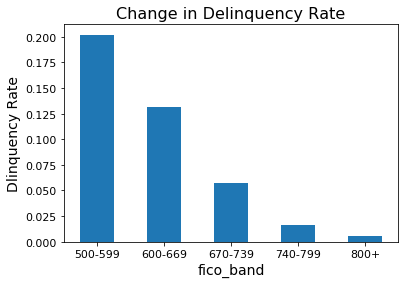

In [12]:
# Clean 2: Make derived variables

### Combine multiple variables
# Define FICO band --> format: '###-###'
# FICO < 600 is considered subprime, FICO >= 780 is considered excellent

def fico_band(fico):
    if fico < 600: 
        return '500-599'
    elif fico < 670:
        return '600-669'
    elif fico < 740:
        return '670-739'
    elif fico < 800:
        return '740-799'
    else:
        return '800+'

# Create the 'fico_band'
df.loc[:,'fico_band']=df.loc[:,'fico'].apply(fico_band)

# Calculate the average for each fico band
df.loc[:,'deli'].groupby(df.loc[:,'fico_band']).mean().plot(kind = 'bar')

plot_format('Change in Delinquency Rate','fico_band','Dlinquency Rate')
plt.show()

In [13]:
### Transform a raw variable
df.loc[:,'other_debt_to_value']=df.loc[:,'cltv']-df.loc[:,'ltv']
df.loc[:,'other_debt_to_this_loan_ratio']=df.loc[:,'other_debt_to_value']/df.loc[:,'ltv']

### Create dummy variable
# As only 13.9% of loans have mortgage insurance
print("mi_pct>0:", 1-len(df[df.loc[:,'mi_pct']==0])/len(df))
df.loc[:,'mi_flag']=np.where(df.loc[:,'mi_pct'] > 0, 1, 0)

### Take a log of dollar amount
# - Dollar amount is usually quite skewed in distribution. A log transformation makes it closer to a normal distribution.
# - It can be used with the raw variable to form a 2-degree variable
df.loc[:,'orig_upb_log'] = df.loc[:,'orig_upb'].apply(lambda x: np.log(x))
df[['orig_upb', 'orig_upb_log','mi_pct','mi_flag']].describe()

mi_pct>0: 0.13923780618235226


,orig_upb,orig_upb_log,mi_pct,mi_flag
count,3365968.00,3365968.00,3365968.00,3365968.00
mean,197440.11,12.04,3.21,0.14
std,108618.11,0.58,8.39,0.35
min,6000.00,8.70,0.00,0.00
25%,113000.00,11.64,0.00,0.00
50%,175000.00,12.07,0.00,0.00
75%,261000.00,12.47,0.00,0.00
max,934000.00,13.75,37.00,1.00


In [14]:
# Clean 3: Remove outlines
df.describe(include=[np.number], percentiles=(0.9, 0.95, 0.98, 0.99))

,fico,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,orig_loan_term,cnt_borr,Period,Act_endg_upb,loan_age,CD_Zero_BAL,delq_sts_num,deli,other_debt_to_value,other_debt_to_this_loan_ratio,mi_flag,orig_upb_log
count,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,59199.00,3364463.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00
mean,751.55,3.21,1.03,69.72,34.36,197440.11,68.49,5.51,327.99,1.55,201040.32,185041.50,21.98,1.14,0.17,0.04,1.23,0.02,0.14,12.04
std,174.88,8.39,0.23,17.34,12.46,108618.11,17.35,0.73,67.72,0.50,135.35,108337.05,14.87,0.95,1.56,0.19,4.72,0.11,0.35,0.58
min,300.00,0.00,1.00,6.00,1.00,6000.00,6.00,3.88,60.00,1.00,200802.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,8.70
50%,760.00,0.00,1.00,75.00,34.00,175000.00,74.00,5.38,360.00,2.00,201009.00,163000.00,20.00,1.00,0.00,0.00,0.00,0.00,0.00,12.07
90%,802.00,17.00,1.00,90.00,51.00,365000.00,90.00,6.50,360.00,2.00,201209.00,349586.62,44.00,1.00,0.00,0.00,0.00,0.00,1.00,12.81
95%,808.00,25.00,1.00,94.00,55.00,416000.00,91.00,6.88,360.00,2.00,201303.00,398323.93,48.00,1.00,0.00,0.00,10.00,0.15,1.00,12.94
98%,813.00,30.00,2.00,95.00,60.00,417000.00,95.00,7.12,360.00,2.00,201308.00,414000.00,52.00,3.00,1.00,1.00,18.00,0.33,1.00,12.94
99%,816.00,30.00,2.00,95.00,63.00,470000.00,95.00,7.25,360.00,2.00,201310.00,451000.00,54.00,9.00,5.00,1.00,25.00,0.51,1.00,13.06
max,9999.00,37.00,4.00,114.00,65.00,934000.00,100.00,9.50,480.00,2.00,201312.00,934000.00,58.00,9.00,52.00,1.00,75.00,7.00,1.00,13.75


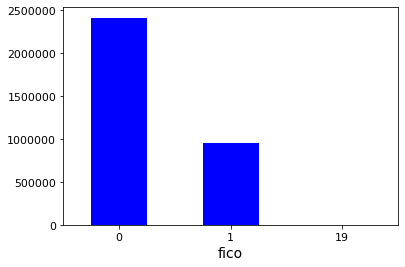

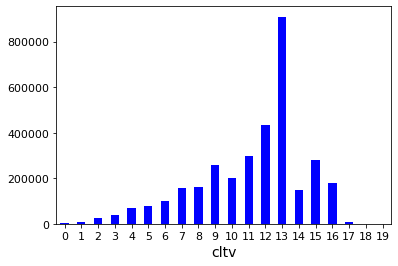

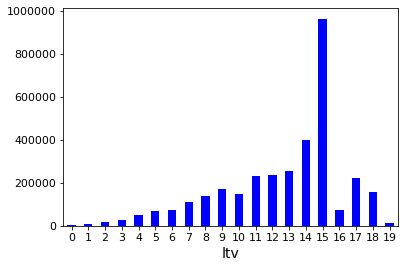

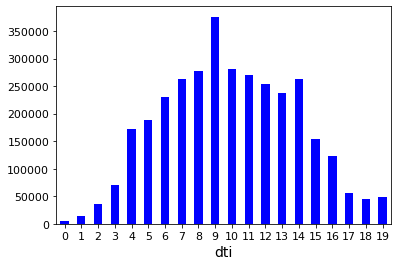

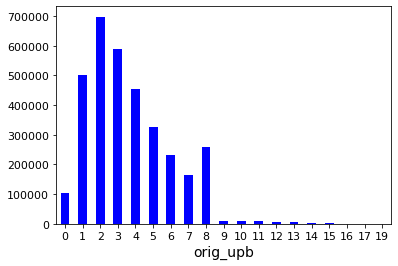

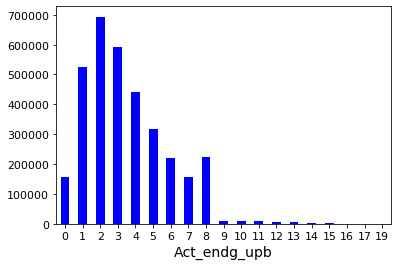

,fico,cltv,ltv,dti,orig_upb,Act_endg_upb
count,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00
mean,751.55,69.72,68.49,34.36,197440.11,185041.50
std,174.88,17.34,17.35,12.46,108618.11,108337.05
min,300.00,6.00,6.00,1.00,6000.00,0.00
25%,717.00,60.00,58.00,25.00,113000.00,103000.00
50%,760.00,75.00,74.00,34.00,175000.00,163000.00
90%,802.00,90.00,90.00,51.00,365000.00,349586.62
95%,808.00,94.00,91.00,55.00,416000.00,398323.93
98%,813.00,95.00,95.00,60.00,417000.00,414000.00
99%,816.00,95.00,95.00,63.00,470000.00,451000.00


In [15]:
# Cut each variable into bins of an equal distribution and see whether a monotonic trend emerges

num_list = ['fico','cltv','ltv','dti','orig_upb','Act_endg_upb']

for num in num_list:
    # cut x into 20 bins according to its value
    df.loc[:,'value_ranks']=pd.cut(df.loc[:,num], 20, labels = False)
    df.groupby(df.value_ranks).size().plot(kind='bar', color='blue')
    plot_format('',num,'')
    plt.show()

# Suppress the outliers for continuous values
df.loc[:,num_list].describe(percentiles=(0.25, 0.5, 0.9, 0.95, 0.98, 0.99))

In [16]:
# Cap the outlier. I choose 98 percentile for each continuous variable
# It also depends on variable behavior, i.e., FICO > 800 shows no behavioral difference, so we cap FICO at 800

df.loc[:,'fico']=np.where(df.loc[:,'fico'] > 800, 800, df.loc[:,'fico'])
df.loc[:,'cltv']=np.where(df['cltv'] > 95, 95, df.loc[:,'cltv'])
df.loc[:,'ltv']=np.where(df['ltv'] > 95, 95, df.loc[:,'ltv'])
df.loc[:,'dti']=np.where(df['dti'] > 60, 60, df.loc[:,'dti'])
df.loc[:,'orig_upb']=np.where(df.loc[:,'orig_upb'] > 417000, 417000, df.loc[:,'orig_upb'])
df.loc[:,'Act_endg_upb']=np.where(df.loc[:,'Act_endg_upb'] > 414000, 414000, df.loc[:,'Act_endg_upb'])

# make sure all model variables have full coverage
# check whether outliers have been capped properly
df[num_list].describe(percentiles=[0.90,0.95, 0.98,0.99])

,fico,cltv,ltv,dti,orig_upb,Act_endg_upb
count,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00
mean,747.61,69.71,68.48,34.31,195813.83,183601.05
std,47.63,17.32,17.33,12.35,103836.61,104044.89
min,300.00,6.00,6.00,1.00,6000.00,0.00
50%,760.00,75.00,74.00,34.00,175000.00,163000.00
90%,800.00,90.00,90.00,51.00,365000.00,349586.62
95%,800.00,94.00,91.00,55.00,416000.00,398323.93
98%,800.00,95.00,95.00,60.00,417000.00,414000.00
99%,800.00,95.00,95.00,60.00,417000.00,414000.00
max,800.00,95.00,95.00,60.00,417000.00,414000.00


### Examine Character Variables

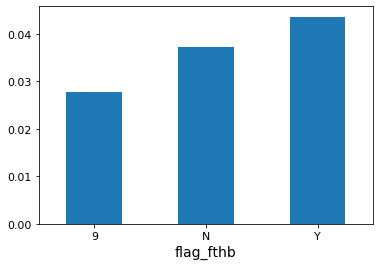

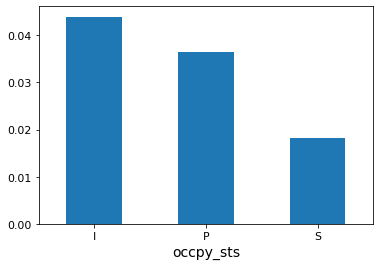

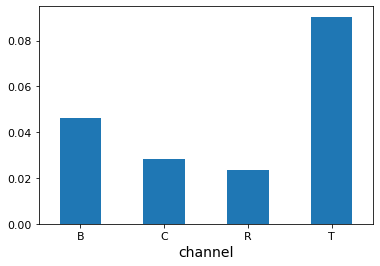

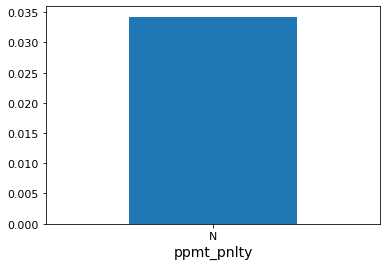

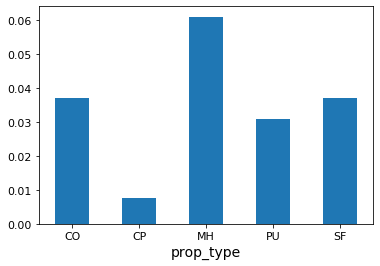

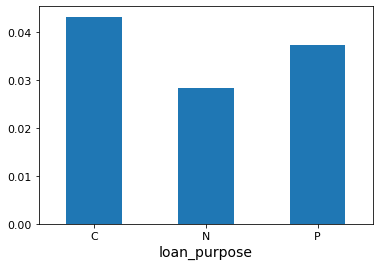

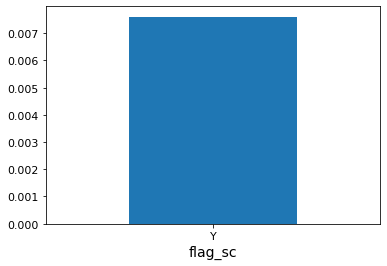

In [17]:
# Collapsing a variable means changing the scale of a variable:
# putting them in class intervals / assigning ranks to the observations. 

char_list = ['flag_fthb','occpy_sts','channel','ppmt_pnlty','prop_type','loan_purpose','flag_sc']

for char in char_list:
    df['deli'].groupby(df[char]).mean().plot(kind = 'bar')
    plot_format('',char,'')
    plt.show()

In [18]:
# Clean 4: Fix with missing values
# ppmt_pnlty and flag_sc contain missing values. They can be imputed easily.
# ppmt_pnlty [['N' nan]]
# flag_sc [[nan 'Y']]
df.loc[df.loc[:,'ppmt_pnlty'].isna(), 'ppmt_pnlty']='Y'
df.loc[df.loc[:,'flag_sc'].isna(), 'flag_sc']='N'

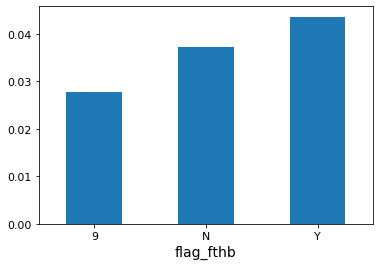

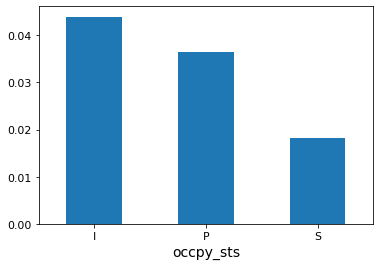

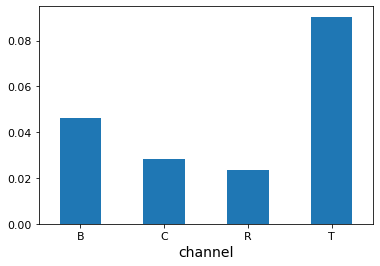

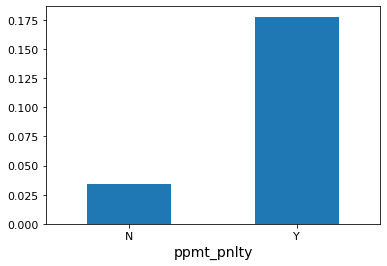

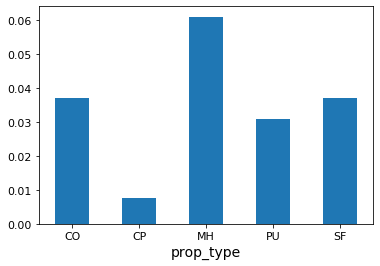

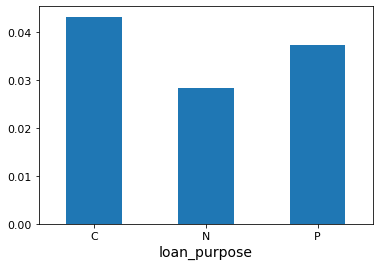

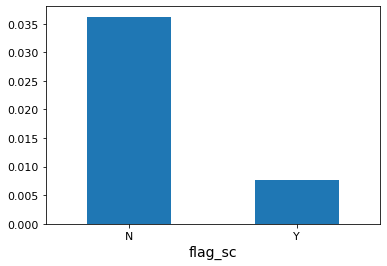

In [19]:
# Clean 2: Make derived variables - Create dummary variable
df.loc[:,'investment_property'] = np.where(df.loc[:,'occpy_sts'] == "I",1,0)
df.loc[:,'prepay_penalty']=np.where(df.loc[:,'ppmt_pnlty'] == "Y",1,0)
df.loc[:,'super_conforming']=np.where(df.loc[:,'flag_sc'] == "Y",1,0)
df.loc[:,'purchase_refinance']=np.where(df.loc[:,'loan_purpose'] == "P",1,0)

# Review the updated variables:
for char in char_list:
    df.loc[:,'deli'].groupby(df.loc[:,char]).mean().plot(kind = 'bar')
    plot_format('',char,'')
    plt.show()

In [20]:
# Clean 5: Drop unneeded variable from the sample

drop_col = ['flag_fthb','mi_pct','occpy_sts','flag_sc','channel','ppmt_pnlty', 'prop_type','id_loan', 'loan_purpose',
            'fico_band','other_debt_to_value','other_debt_to_this_loan_ratio','delq_sts','delq_sts_num',
            'Period','CD_Zero_BAL','value_ranks']


df_vif = df.drop(drop_col, axis=1)

In [21]:
# Clean 6: VIF analysis for multicollinearity

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_vif
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,285.77,fico
1,23.52,cnt_units
2,245.12,cltv
3,10.08,dti
4,48.68,orig_upb
5,245.63,ltv
6,86.86,int_rt
7,30.11,orig_loan_term
8,11.73,cnt_borr
9,39.37,Act_endg_upb


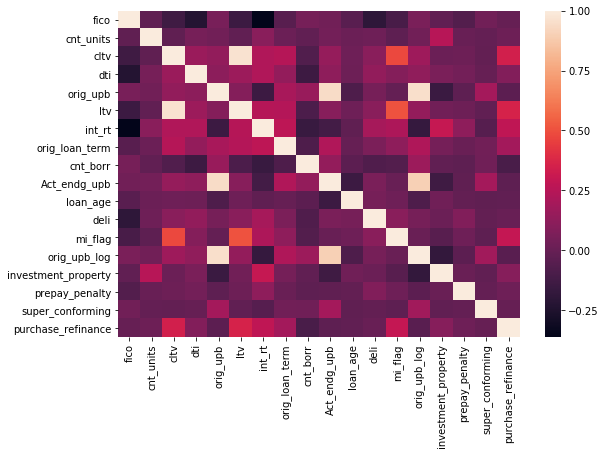

In [22]:
# check correlation
fig = plt.figure(figsize = (9,6))
sns.heatmap(df_vif.corr())
plt.show()

In [23]:
# Drop orig_upb_log, ltv and Act_endg_upb based on VIF result

df_model = df_vif.drop(['orig_upb_log','ltv','Act_endg_upb'], axis=1)
df_model.describe()

,fico,cnt_units,cltv,dti,orig_upb,int_rt,orig_loan_term,cnt_borr,loan_age,deli,mi_flag,investment_property,prepay_penalty,super_conforming,purchase_refinance
count,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00
mean,747.61,1.03,69.71,34.31,195813.83,5.51,327.99,1.55,21.98,0.04,0.14,0.06,0.01,0.01,0.31
std,47.63,0.23,17.32,12.35,103836.61,0.73,67.72,0.50,14.87,0.19,0.35,0.24,0.11,0.09,0.46
min,300.00,1.00,6.00,1.00,6000.00,3.88,60.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,717.00,1.00,60.00,25.00,113000.00,4.88,360.00,1.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,760.00,1.00,75.00,34.00,175000.00,5.38,360.00,2.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,788.00,1.00,80.00,44.00,261000.00,6.00,360.00,2.00,33.00,0.00,0.00,0.00,0.00,0.00,1.00
max,800.00,4.00,95.00,60.00,417000.00,9.50,480.00,2.00,58.00,1.00,1.00,1.00,1.00,1.00,1.00


## Data Modeling

In [24]:
# Split the sample by 60/40 to make a modeling sample and a validation sample

# Use the following variable to split the smaple
df_model['random_temp']=np.random.uniform(0, 1, len(df_model))
split_pct=0.4

samp_train=df_model.loc[df_model['random_temp'] > split_pct]
samp_test=df_model.loc[df_model['random_temp'] <= split_pct]
samp_train.info()

# Second Method to split the sample:
# df_model['index'] = df_model.set_index()
# samp_train = df_model.sample(round(len(df_model)*split_pct))
# samp_test = df_model[~df_model['index'].isin (samp_train['index'])]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2019903 entries, 0 to 3407831
Data columns (total 16 columns):
fico                   int64
cnt_units              int64
cltv                   int64
dti                    int64
orig_upb               int64
int_rt                 float64
orig_loan_term         int64
cnt_borr               int64
loan_age               int64
deli                   int64
mi_flag                int64
investment_property    int64
prepay_penalty         int64
super_conforming       int64
purchase_refinance     int64
random_temp            float64
dtypes: float64(2), int64(14)
memory usage: 262.0 MB


### Logit Model

In [27]:
import statsmodels.api as sm

# Create the intercept variable 
samp_train['intercept']=1

# Or using add_constant()
# from statsmodels.tools import add_constant
# x_train = add_constant(x_train)

y_train = samp_train.loc[:,'deli']
x_train = samp_train.drop(['deli','random_temp'],axis=1)

logitreg = sm.Logit(y_train,x_train)

result = logitreg.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.115880
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   deli   No. Observations:              2019903
Model:                          Logit   Df Residuals:                  2019888
Method:                           MLE   Df Model:                           14
Date:                Tue, 22 Dec 2020   Pseudo R-squ.:                  0.2532
Time:                        16:08:05   Log-Likelihood:            -2.3407e+05
converged:                       True   LL-Null:                   -3.1344e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
fico                   -0.0107   8.53e-05   -124.855      0.000      -0.011      -0.010
cnt_units               0.0766      0.014      5.395      0.000       0.049       0.104
cltv                    0.0315      0.000     71.348      0.000       0.031       0.032
dti                     0.0337      0.000     89.760      0.000       0.033       0.034
orig_upb             4.378e-06   4.19e-08    104.479      0.000     4.3e-06    4.46e-06
int_rt                  1.0563      0.007    144.745      0.000       1.042       1.071
orig_loan_term          0.0018      0.000     17.269      0.000       0.002       0.002
cnt_borr               -0.7152      0.009    -82.270      0.000      -0.732      -0.698
loan_age                0.0174      0.000     65.074      0.000       0.017       0.018
mi_flag                 0.2761      0.012     23.475      0.000       0.253       0.299
investment_property    -0.2721      0.017    -16.260      0.000      -0.305      -0.239
prepay_penalty          0.7341      0.020     36.146      0.000       0.694       0.774
super_conforming       -1.0790      0.091    -11.898      0.000      -1.257      -0.901
purchase_refinance     -0.8075      0.010    -83.443      0.000      -0.826      -0.789
intercept              -6.2495      0.097    -64.731      0.000      -6.439      -6.060
=======================================================================================
"""

In [28]:
coef = result.params.values
print(coef,'\n')

samp_train.loc[:,'rawscore'] = (x_train * coef).sum(axis = 1)
samp_train.loc[:,'default_score']=samp_train.loc[:,'rawscore'].apply(lambda x:1/(1+np.exp(-1*x)))

print(samp_train[['deli', 'default_score']].mean())


[-1.06510453e-02  7.66099761e-02  3.14855395e-02  3.36740547e-02
  4.37784709e-06  1.05629245e+00  1.84300390e-03 -7.15211137e-01
  1.73737101e-02  2.76085425e-01 -2.72100472e-01  7.34079485e-01
 -1.07895539e+00 -8.07484087e-01 -6.24951038e+00] 

deli            0.04
default_score   0.04
dtype: float64


            default_score  deli
dist_ranks                     
0                    0.00  0.00
1                    0.00  0.00
2                    0.00  0.00
3                    0.01  0.00
4                    0.01  0.01
5                    0.01  0.01
6                    0.02  0.02
7                    0.03  0.04
8                    0.06  0.07
9                    0.21  0.20
AxesSubplot(0.125,0.125;0.775x0.755)


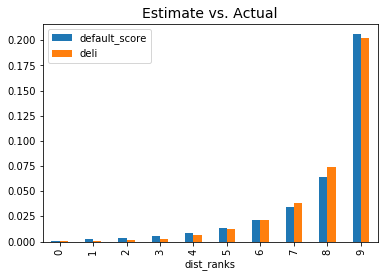

In [29]:
samp_train.loc[:,'dist_ranks']=pd.qcut(samp_train.loc[:,"default_score"], 10, labels=False, duplicates="drop")
rank_def_deli = samp_train[['default_score', 'deli']].groupby(samp_train['dist_ranks']).mean()
print(rank_def_deli)
print(rank_def_deli.plot(kind = 'bar'))

plt.title('Estimate vs. Actual', fontsize=14)
plt.show()

deli            0.04
default_score   0.04
dtype: float64
            default_score  deli
dist_ranks                     
0                    0.00  0.00
1                    0.00  0.00
2                    0.00  0.00
3                    0.01  0.00
4                    0.01  0.01
5                    0.01  0.01
6                    0.02  0.02
7                    0.03  0.04
8                    0.06  0.07
9                    0.21  0.20
AxesSubplot(0.125,0.125;0.775x0.755)


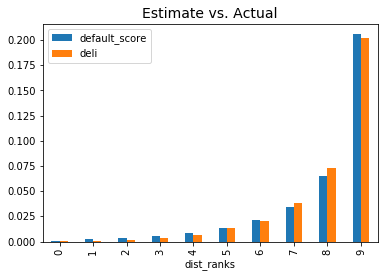

In [30]:
# Sample Validation

samp_test['intercept']=1

x_test = samp_test.drop(['deli','random_temp'],axis=1)

samp_test.loc[:,'rawscore'] = (x_test * coef).sum(axis=1)
samp_test.loc[:,'default_score']=samp_test.loc[:,'rawscore'].apply(lambda x:1/(1+np.exp(-1*x)))

print(samp_test[['deli', 'default_score']].mean())

samp_test.loc[:,'dist_ranks']=pd.qcut(samp_test.loc[:,"default_score"], 10, labels=False, duplicates="drop")
rank_def_deli = samp_test[['default_score', 'deli']].groupby(samp_test['dist_ranks']).mean()
print(rank_def_deli)
print(rank_def_deli.plot(kind = 'bar'))

plt.title('Estimate vs. Actual', fontsize=14)
plt.show()

In [31]:
# calculate KS statistics
samp_train.loc[:,'good']=1-samp_train.loc[:,'deli']
samp_test.loc[:,'good']=1-samp_test.loc[:,'deli']

In [32]:
# ks for training
samp_train.loc[:,'bucket'] = pd.qcut(samp_train.default_score, 10)
grouped = samp_train.groupby('bucket', as_index = False)

agg1 = grouped.min().default_score
agg2 = grouped.max().default_score
agg3 = grouped.count().default_score
agg4 = grouped.sum().deli
agg5 = grouped.sum().good

agg = pd.concat([agg1,agg2,agg3,agg4,agg5], axis=1)
agg.columns = ['min_scr','max_scr','total','bads','goods']

agg['bad_rate (%)'] = round(agg['bads'] / agg['total'] * 100,2)
agg['cum_bad_rate (%)'] = round(agg['bads'].cumsum() / agg['bads'].sum() * 100,2) # tpr
agg['cum_good_rate (%)'] = round(agg['goods'].cumsum() / agg['goods'].sum() * 100,2) # fpr
agg['ks'] = abs(agg['cum_bad_rate (%)'] - agg['cum_good_rate (%)'])
agg['max_ks'] = np.where(agg.ks == agg.ks.max(),"<-----","")

print("ks = ", round(max(agg.ks),2))
agg

ks =  59.43


,min_scr,max_scr,total,bads,goods,bad_rate (%),cum_bad_rate (%),cum_good_rate (%),ks,max_ks
0,0.00,0.00,201991,63,201928,0.03,0.09,10.37,10.28,
1,0.00,0.00,201990,138,201852,0.07,0.28,20.74,20.46,
2,0.00,0.00,201990,273,201717,0.14,0.65,31.10,30.45,
3,0.00,0.01,201990,595,201395,0.29,1.47,41.44,39.97,
4,0.01,0.01,201991,1312,200679,0.65,3.27,51.75,48.48,
5,0.01,0.02,201990,2610,199380,1.29,6.85,61.99,55.14,
6,0.02,0.03,201990,4267,197723,2.11,12.71,72.14,59.43,<-----
7,0.03,0.05,201990,7757,194233,3.84,23.37,82.12,58.75,
8,0.05,0.09,201990,14903,187087,7.38,43.83,91.73,47.90,
9,0.09,0.96,201991,40897,161094,20.25,100.00,100.00,0.00,


In [33]:
# ks for testing
samp_test['bucket'] = pd.qcut(samp_test.default_score, 10)
grouped = samp_test.groupby('bucket', as_index = False)
agg1 = grouped.min().default_score
agg2 = grouped.max().default_score
agg3 = grouped.count().default_score
agg4 = grouped.sum().deli
agg5 = grouped.sum().good

agg = pd.concat([agg1,agg2,agg3,agg4,agg5], axis=1)
agg.columns = ['min_scr','max_scr','total','bads','goods']

agg['bad_rate (%)'] = round(agg['bads'] / agg['total'] * 100,2)
agg['cum_bad_rate (%)'] = round(agg['bads'].cumsum() / agg['bads'].sum() * 100,2) # tpr
agg['cum_good_rate (%)'] = round(agg['goods'].cumsum() / agg['goods'].sum() * 100,2) # fpr
agg['ks'] = abs(agg['cum_bad_rate (%)'] - agg['cum_good_rate (%)'])
agg['max_ks'] = np.where(agg.ks == agg.ks.max(),"<-----","")

print("ks = ", round(max(agg.ks),2))
agg

# Meaning:
# If we choose 0.03 as cutoff (reject if the score lower than this value), we can reject 13.99% bad id correctly

# The bigger ks, the better result (separate good and bad id), but usually less than 52% (unless there is overfitting)

ks =  59.23


,min_scr,max_scr,total,bads,goods,bad_rate (%),cum_bad_rate (%),cum_good_rate (%),ks,max_ks
0,0.00,0.00,134607,48,134559,0.04,0.10,10.37,10.27,
1,0.00,0.00,134606,84,134522,0.06,0.27,20.73,20.46,
2,0.00,0.00,134607,184,134423,0.14,0.65,31.09,30.44,
3,0.00,0.01,134606,411,134195,0.31,1.50,41.43,39.93,
4,0.01,0.01,134607,893,133714,0.66,3.35,51.74,48.39,
5,0.01,0.02,134606,1815,132791,1.35,7.11,61.97,54.86,
6,0.02,0.03,134606,2803,131803,2.08,12.90,72.13,59.23,<-----
7,0.03,0.05,134607,5109,129498,3.80,23.47,82.11,58.64,
8,0.05,0.09,134606,9852,124754,7.32,43.85,91.72,47.87,
9,0.09,0.96,134607,27146,107461,20.17,100.00,100.00,0.00,


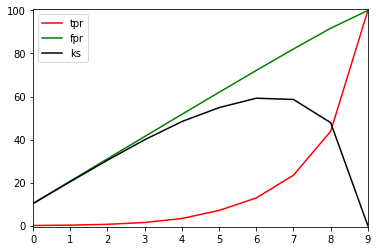

In [34]:
agg['cum_bad_rate (%)'].plot(label = 'tpr', c = 'red')
agg['cum_good_rate (%)'].plot(label = 'fpr', c = 'green')
agg['ks'].plot(label = 'ks', c = 'black')

plt.ylim([-0.5, 100.5])

plt.legend()

In [35]:
# The modeling exercise for this project has ended in the above section. 
# The following exercise is to compare logistic regression and decision tree only.

samp_train=df_model.loc[df_model['random_temp'] > split_pct]
samp_test=df_model.loc[df_model['random_temp'] <= split_pct]

x_train = samp_train.drop(['deli','random_temp'],axis=1)
y_train = samp_train['deli']

x_test = samp_test.drop(['deli','random_temp'],axis=1)
y_test = samp_test['deli']

### Logistic Regression


In [36]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression(solver='lbfgs')
logreg.fit(x_train, y_train)

print("log_intercept:", logreg.intercept_)
print("log_coef:", logreg.coef_,"\n")

y_pred_proba = logreg.predict_proba(x_test)
y_pred = logreg.predict(x_test)

print("Predict Y by proability:\n", y_pred_proba)
print("Predict Y by class:\n",y_pred,'\n')

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))


log_intercept: [0.00012203]
log_coef: [[-1.53601482e-02  4.25962172e-04  4.21600963e-02  4.55552721e-02
   2.41358330e-06  6.49158168e-03  5.88992511e-03 -2.20621541e-03
   1.42040073e-02  1.11435414e-03  2.78479678e-04  5.16912280e-04
  -1.03431571e-04 -8.46727267e-04]] 

Predict Y by proability:
 [[9.69390454e-01 3.06095459e-02]
 [9.67658861e-01 3.23411392e-02]
 [9.66298404e-01 3.37015957e-02]
 ...
 [9.99813403e-01 1.86596753e-04]
 [9.99810734e-01 1.89265582e-04]
 [9.99808027e-01 1.91972575e-04]]
Predict Y by class:
 [0 0 0 ... 0 0 0] 

Accuracy of logistic regression classifier on test set: 0.96


In [42]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

# prepare the cross-validation procedure
cv = model_selection.KFold(n_splits=10, random_state=7)

# create model
model = LogisticRegression(solver='lbfgs',max_iter=5) # If error -> increase max_iter

# evaluate model
scores = model_selection.cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv)

# report performance
print("10-fold cross validation average accuracy: %.3f" % (scores.mean()))

10-fold cross validation average accuracy: 0.964


In [38]:
### Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix,"\n")

print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1297046     674]
 [  47991     354]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98   1297720
           1       0.34      0.01      0.01     48345

    accuracy                           0.96   1346065
   macro avg       0.65      0.50      0.50   1346065
weighted avg       0.94      0.96      0.95   1346065



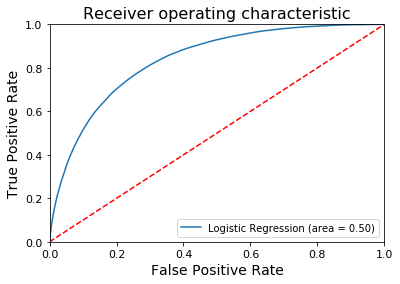

In [39]:
### ROC_AUC Score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plot_format('Receiver operating characteristic','False Positive Rate','True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Decision Tree

In [40]:
from sklearn import tree
from sklearn.metrics import accuracy_score

deci_tree = tree.DecisionTreeClassifier(criterion = "gini", # default -> or criterion = "entropy"
                                        random_state = 100,
                                        max_depth = 18,
                                        min_samples_leaf = 5) # min_sample required to be at a leaf node

deci_tree.fit(x_train, y_train)
y_pred = deci_tree.predict(x_test)
print ("Accuracy is {:.2f}".format(accuracy_score(y_test,y_pred)))

Accuracy is 0.99


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1297720
           1       0.92      0.76      0.83     48345

    accuracy                           0.99   1346065
   macro avg       0.95      0.88      0.91   1346065
weighted avg       0.99      0.99      0.99   1346065

